# Measuring a Screaming Channels Leak in Satellite Transceivers

This is a companion notebook for the article titled *Measuring a Screaming Channels Leak in Satellite Transceivers*.  This notebook is designed to take traces obtained single encryption cycles on small satellite system-on-a-chip transceivers. The signals are assumed to have been created using the process described in that article and the related <a href="https://github.com/GallagherTom/screaming_satellites">GitHub repository</a>. 

Note that this analysis will make changes to the traces in the configured locations. Ensure that you have backed up traces before analysis.

In general, this notebook follows the following structure:
+ **<a href="#align_traces">Filter & Align Traces</a>**: Remove any traces that are not close to the median length and then align the remaining traces
    + This section was moved into a dedicated notebook
    + Note that **this is a disk altering process** as it will replace traces in the specified location with aligned versions of each trace. Make sure that you are not working from your only copy of data.
    + Alignment is accomplished using the <a href="https://github.com/pearsonkyle/Signal-Alignment">phase alignment algorithm</a>
+ **<a href="#nb_setup">Setup</a>**: Load Required modules and define helper functions.
    + Note that signal_alignment is not installable via pip and can be found <a href="https://github.com/pearsonkyle/Signal-Alignment">here</a> instead.
+ **<a href="#configure">Configure Environment</a>**: Specify configuration settings
    + Specifying the file trace locations is the only *required* configuration. Other configuration changes can hone analysis or enhance performance.
    + There are two required sets of traces.
        + Variable Key traces: each trace should use a random key. The group should all use the same plaintext. Signal-to-Noise calculations are done on the Variable key traces and the analysis is dependent on a normal distribution of random data for the keys
        + Fixed Key traces: each traces should use the same key and plain text. The fixed key traces are only used for the t-test to compare against the variable key traces.
    + This section provides the ability to view 3 random traces which can provide an easy way to visualize similarities between the traces that may present obvious trimmable area or points of interest for alignment
+ **<a href="#load_metadata">Load Metadata</a>**: Loads keys and plaintext for the traces
    + For the variable trace group, *key_.txt* file should contain a line for every trace where the line specifies the 16-character hexidecimal value of the key used for that trace (e.g., dda0a7f10791853b7d2ff16643caf642). For the fixed key group, *key_.txt* should have a single line that specifies the key used for every trace.
    + For each group, *pt_.txt* should contain a single line where the plaintext data of the encryption is provided as a 16-character hexidecimal value (e.g., dda0a7f10791853b7d2ff16643caf642)
+ **<a href="#load_and_analyze">Load/Analyze Data</a>**: Loads a segment of every trace and performs described analysis
    + This code works on portions of the data at a time instead of trying to load the entirety of every trace at once. By using segments, the analysis can be performed in a reasonable amount of RAM. If a system is experiencing out-of-memory issues, try lowering the *segment_length* in the Setup section
    + For each segment, that portion of every trace is loaded and the t-test and SNR tests are performed at every time slice. The resultant data is added to aggregation arrays so that every calculation will be available once all segments are processed
    + The aggregated data is saved to disk as *SNRs.npy* and *TTest.npy* allowing for faster access to the results later. A commented out code block would allow this data to be loaded for graphing or further analysis
+ **<a href="#ttest">Display T-test Results</a>**: Shows the aggregated results of the t-test
    + The t-test compares the mean/variance of the variable key traces and fixed key traces for every time slice. The theory is that if the value of the key has no impact on the resultant trace, then the groups should have the same mean. 
    + p-value is the probability of seeing the observed traces by chance if there truly is no difference in the group means. In other words, a low p-value indicates that it is extremely unlikely that the value of the key is not impactful to the signal.
    + Note that p-values for this t-test could range wildly from very close to zero to 1.0. To make the graph meaningful, adjust *pval_threshold* in the code to show the area where the pvals are lowest or below some level prescribed by the need for confidence.
    + The areas where the p-value is very low may provide a good range to focus on for SNR calculations
    + The t-test was adapted from the <a href="https://cryptography.gmu.edu/documentation/fobos/index.html">Flexible Opensource workBench fOr Side-channel analysis</a> (FOBOS) <a href="https://cryptography.gmu.edu/documentation/fobos/t_test.html">t-test alogirthm</a>
+ **<a href="#snr">Display Signal-to-Noise Results</a>**: Shows the aggregated results of the Signal-to-Noise calculations
    + The code for the SNR calculations was adapted from the <a href="https://github.com/ileanabuhan/LeakageAssessment/blob/main/SNR.ipynb">SNR Tutorial</a> provided by Ileana Buhan along with the <a href="https://ileanabuhan.github.io/general/2021/05/07/SNR-tutorial.html">related blog</a>.
    + The graphs show the SNR calculations for each specified leakage model. The code is designed to be modular so additional leakage models can be dropped in if needed.
    + The SNR ratio provides detail at the byte-level about where the traces may leak information about the cryptographic key


## Filter & Align Traces<a id="align_traces"></a>

The routine to align traces was moved into its own dedicated notebook

## Setup<a id='nb_setup'></a>

In [1]:
# Load required Python modules
import os, random, gc
from scipy import stats, signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#progress bar for visualization of progress
from tqdm import tqdm 

In [2]:
# This cell contains helper functions and data structures that will be used in the analysis

# defines the Rijndael S-box used by the Advanced Encryption Standard (AES)
sbox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
            0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
            0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
            0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
            0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
            0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
            0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
            0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
            0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
            0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
            0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
            0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
            0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
            0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
            0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
            0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
            0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
            0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
            0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
            0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
            0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
            0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
            0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
            0x54, 0xbb, 0x16]

# Labels data in preparation for Signal-to-Noise Analysis
def prepare_data(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = the leakage model of the target intermediate value
    
    returns a dictionary of the form
       'label_value': list of traces associated with 'label_value'
    """
   
    labels=np.unique(labels_set)
    #initialize the dictionary
    d={}
    for i in labels:
         d[i]=[]
    for count, label in enumerate(labels_set):
        d[label].append(trace_set[count])
    return d

# Perform Signal-to-Noise analysis as described https://ileanabuhan.github.io/general/2021/05/07/SNR-tutorial.html
def return_snr_trace(trace_set, labels_set):
    """
    trace_set = a set of traces
    labels_set = a set of labels of the same lenght as trace_set
    
    returns a dictionary of the form
       'label_value': mean_sample trace with 'label_value'
    """
    mean_trace={}
    signal_trace=[]
    noise_trace=[]
    labels=np.unique(labels_set) #determine the set of unique values for the leakage model
    #for LSB and MSB, labels ={0,1} and for HW, labels={0,1,2,3,4,5,6,7}
    grouped_traces=prepare_data(trace_set, labels_set) # we group the traces according to the label
    #compute the mean trace (the same are the signal traces)   
    for i in labels:
        mean_trace[i]=np.mean(grouped_traces[i], axis=0)
        signal_trace.append(mean_trace[i]) 
    #compute the noise trace  
    for i in labels:
        for trace in grouped_traces[i]:
            #if((trace-mean_trace[i]).any() == 0):
            #    print(trace)
            noise_trace.append(trace-mean_trace[i])
    var_noise=np.var(noise_trace, axis=0)
    var_signal=np.var(signal_trace, axis=0)
    snr_trace=var_signal/var_noise  
    return snr_trace   

# Helper function that allows iterative calling of SNR for any defined leakage model
def calc_SNRs(func, keys, pts, traces):
    SNRs = {}
    for _target_byte, dummy in enumerate(keys[0]):
        labels=[] #the label to divide the data
        for x, pt in enumerate(pts):
            labels.append(func(sbox, keys[x][_target_byte], int(pt[_target_byte])))
        SNRs[_target_byte] = return_snr_trace(traces, labels)
    return SNRs

# Define the leakage models by how each byte of key and plaintext interact
def HammingWeightHelper(x):
    return sum([x&(1<<i)>0 for i in range(32)])
def LSB(sbox, key_byte, pt_byte):
    return sbox[key_byte ^ pt_byte]&0b1
def LSB2(sbox, key_byte, pt_byte):
    return sbox[key_byte ^ pt_byte]&0b11
def MSB(sbox, key_byte, pt_byte):
    return sbox[key_byte ^ pt_byte]&0b10000000
def HW(sbox, key_byte, pt_byte):
    return HammingWeightHelper(sbox[key_byte ^ pt_byte])


# Perform a t-test as defined by https://cryptography.gmu.edu/documentation/fobos/t_test.html
def ttest(traces0, traces1):
    minLen = min(len(traces0), len(traces1))
    traces0 = traces0[0:minLen]
    traces1 = traces1[0:minLen]
    
    t = np.empty(traces0.shape[1])
    for i in range(len(t)):
        t[i] = stats.ttest_ind(traces0[:, i], traces1[:, i], equal_var=True)[1] #1 is the pvalue, 0 is t statistic
    return t

# Helper function to return directory contents sorted by datetime (oldest first)
def sorted_ls(path, sortby="mtime", require_ext=False):
    if sortby=="fsize":
        sortkey = lambda f: os.path.getsize(os.path.join(path, f))
    else:
        sortkey = lambda f: os.stat(os.path.join(path, f)).st_mtime
    file_list = list(sorted(os.listdir(path), key=sortkey))
    if require_ext != False:
        file_list = [x for x in file_list if x.endswith(require_ext)]
    return file_list

# Helper function to standardize graphs and reduce code size
def ShowTrace(title, xlabel, ylabel, ydata, fig_size=(10, 6), xdata=None, ylim=None):
    plt.figure(figsize=fig_size, dpi=80)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim!= None:
        ax = plt.gca()
        ax.set_ylim([0, ylim]) 
    if xdata!= None:
        plt.plot(xdata, ydata)
    else:
        plt.plot(ydata)
    plt.show()


## Configure Environment<a id="configure"></a>

In [3]:
# Specify where the traces are located

#Specify the Directory for traces created with a random key and fixed plaintext
varkey_dir = "traces/cc1111-varkey/"
varkey_path = varkey_dir+"/output/"

#Specify the Directory for traces created with a fixed key and fixed plaintext
fixedkey_dir = "traces/cc1111-fixedkey/"
fixedkey_path = fixedkey_dir+"/output/"

#For convenience of iterating, bundle the directories into a single object
paths = {varkey_path:"Variable keys", fixedkey_path:"Fixed keys"}

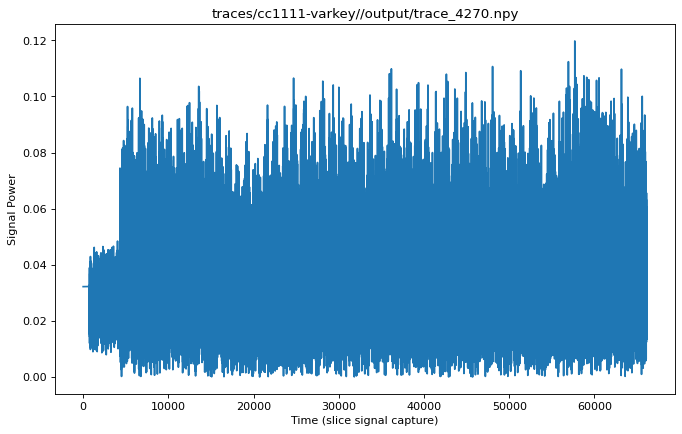

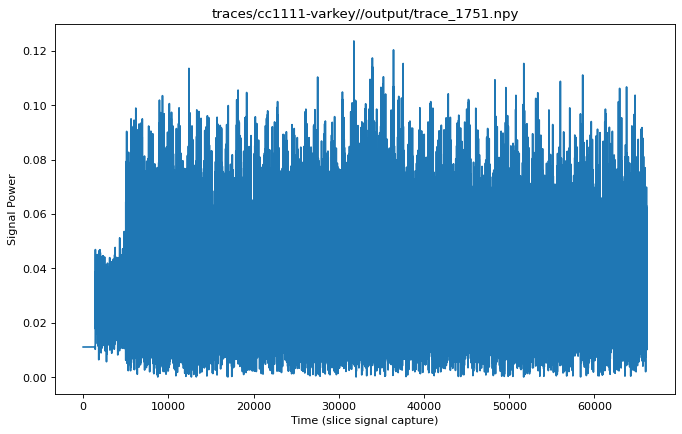

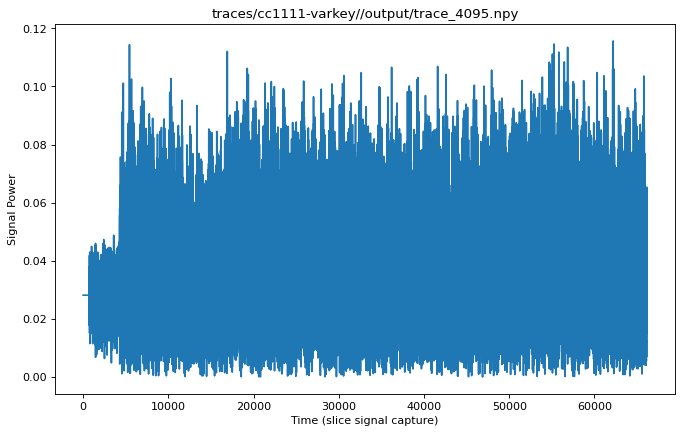

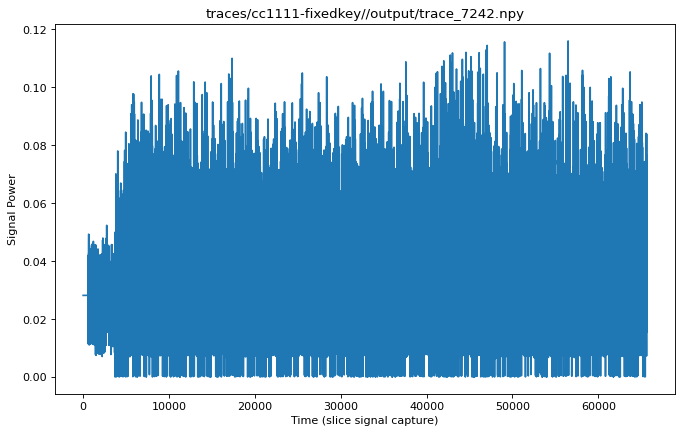

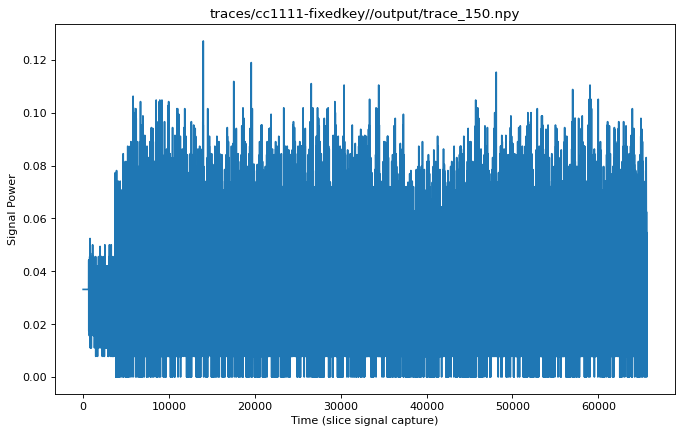

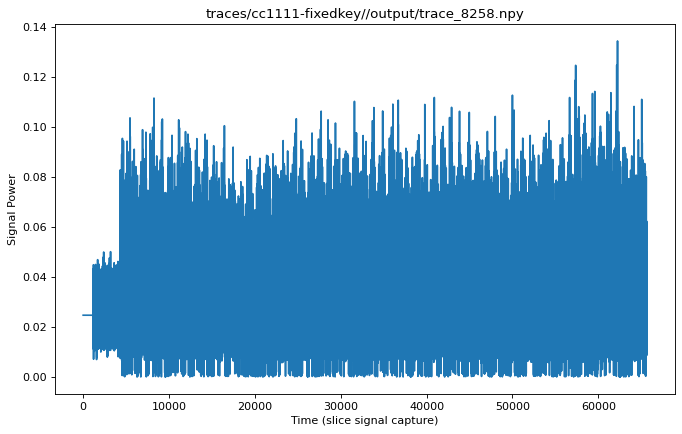

In [4]:
# Get a quick view of 3 random traces from each group
# This is helpful if there is obvious data to trim or points of interest for alignment
for path in paths:
    for i in range(3):
        filename = random.choice(sorted_ls(path, require_ext=".npy"))
        glance = np.absolute(np.load(path+filename))
        ShowTrace(path+filename, "Time (slice signal capture)", "Signal Power", glance)

In [5]:
# This section provides some configuration information that can help analysis performance

# Determines what size chunk the analysis will be performed on
# Reduce this if encountering out-of-memory errors
segment_length = 20000  

# If a known range at the beginning or end of the trace can be discarded, specify that here
#trim_lower_bound = 0 #0 means don't trim beginning
#trim_upper_bound = 0 #0 means don't trim end

# Define some parameters for this specific analysis
single_key_mode = False #For this notebook, we'll consider variable keys
single_pt_mode = True #For this notebook, we'll consider fixed plaintext
LIMIT_TRACES = False #False means don't limit (this should be False unless troubleshooting)

# Define the models to be considered for ease of iteration
Models = {"LSB":LSB, "LSB2":LSB2, "MSB":MSB, "HW":HW }


## Load Metadata<a id="load_metadata"></a>

In [6]:
# Load Keys and Plaintexts of the variable key traces 
# Because we removed bad traces, we need to re-correlate each trace to the correct key
# we ignore keys/plaintext for fixed key traces as they are only used for t-test whereas variable key traces are used for SNR tests
plaintexts, keys = [], []

with open(varkey_path+"key_.txt") as keys_text:
    orig_keys = keys_text.readlines()
    
with open(varkey_path+"pt_.txt") as pt_text:
    orig_plaintext = pt_text.readlines()

dir_list = sorted_ls(varkey_path, sortby="mtime", require_ext=".npy")
for filename in tqdm(dir_list, desc="Loading Keys and Plaintext"):
    trace_index = int(''.join(c for c in filename if c.isdigit())) #number in the trace filename is the key/pt index
    key = orig_keys[0] if single_key_mode else orig_keys[trace_index]
    pt = orig_plaintext[0] if single_pt_mode else orig_plaintext[trace_index]
    keys.append(bytearray.fromhex(key.strip()))
    plaintexts.append(bytearray.fromhex(pt.strip()))
        
#free memory
orig_plaintext, orig_keys = [], []
dummy = gc.collect()

Loading Keys and Plaintext: 100%|███████| 9998/9998 [00:00<00:00, 433003.44it/s]


## Load and Analyze Data Segments<a id="load_and_analyze"></a>

In [7]:
# Load segments of each trace and perform calculations
# Loading a segment at a time prevents out of memory errors
SNRs, TTest = {}, []

# Get length of each trace (it is assumed that these traces are equal lengths)
filename = random.choice(sorted_ls(varkey_path, require_ext=".npy"))
trace_length = len(np.load(varkey_path+filename))
        
lower_bound, upper_bound = 0, segment_length-1
while (lower_bound < trace_length):
    orig_traces =  {}
    gc_counter = 0
    for path in paths:
        orig_traces[path] = []
        dir_list = sorted_ls(path, sortby="mtime", require_ext=".npy")
        for filename in tqdm(dir_list, desc="Loading Traces, Segment "+str(int((upper_bound+1)/segment_length))+" of "+str(int(np.ceil(trace_length/segment_length)))+" for "+paths[path]):
            if (LIMIT_TRACES == False or len(orig_traces[path]) <= LIMIT_TRACES):
                trace = np.load(path+filename, mmap_mode="r")
                orig_traces[path].append(np.absolute(trace[lower_bound:upper_bound]))
                del trace
                gc_counter+=1
            if(gc_counter > 100):
                dummy = gc.collect()
                gc_counter = 0

    #convert to Numpy array since all traces are now equal length
    traces_variable = np.array(orig_traces[varkey_path])
    traces_fixed = np.array(orig_traces[fixedkey_path])
    
    #free memory
    orig_traces = {}
    dummy = gc.collect()

    # Perform the SNR and T-test for this segment
    SNRs[lower_bound] = {}
    for model in tqdm((Models | {"TTest":""}), desc="  Processing Tests, Segment "+str(int((upper_bound+1)/segment_length))+" of "+str(int(np.ceil(trace_length/segment_length)))+" for "+paths[path]):
        if model == "TTest":
            TTest.extend(ttest(traces_fixed, traces_variable))
        else:
            SNRs[lower_bound][model] = calc_SNRs(Models[model], keys, plaintexts, traces_variable)

    #increment bounds for the next loop
    lower_bound += segment_length
    upper_bound += segment_length

# Save the test data (allows us to start the analysis from this point later if desired)
np.save(varkey_dir+"/SNRs.npy", SNRs)
np.save(varkey_dir+"/TTest.npy", TTest)

Loading Traces, Segment 1 of 4 for Variable keys: 100%|█| 9998/9998 [00:24<00:00
Loading Traces, Segment 1 of 4 for Fixed keys: 100%|█| 9998/9998 [00:24<00:00, 4
  Processing Tests, Segment 1 of 4 for Fixed keys: 100%|█| 5/5 [02:55<00:00, 35.
Loading Traces, Segment 2 of 4 for Variable keys: 100%|█| 9998/9998 [00:29<00:00
Loading Traces, Segment 2 of 4 for Fixed keys: 100%|█| 9998/9998 [00:27<00:00, 3
  Processing Tests, Segment 2 of 4 for Fixed keys: 100%|█| 5/5 [02:52<00:00, 34.
Loading Traces, Segment 3 of 4 for Variable keys: 100%|█| 9998/9998 [00:23<00:00
Loading Traces, Segment 3 of 4 for Fixed keys: 100%|█| 9998/9998 [00:25<00:00, 3
  Processing Tests, Segment 3 of 4 for Fixed keys: 100%|█| 5/5 [02:54<00:00, 34.
Loading Traces, Segment 4 of 4 for Variable keys: 100%|█| 9998/9998 [00:20<00:00
Loading Traces, Segment 4 of 4 for Fixed keys: 100%|█| 9998/9998 [00:21<00:00, 4
  Processing Tests, Segment 4 of 4 for Fixed keys: 100%|█| 5/5 [00:43<00:00,  8.


In [8]:
# This section should be commented out unless you want to resume a previous run from the saved SNR/TTest files
#SNRs = np.load(varkey_dir+"/SNRs.npy", allow_pickle=True)
#SNRs = SNRs.item()
#TTest = np.load(varkey_dir+"/TTest.npy", allow_pickle=True)

## Display T-test Results<a id="ttest"></a>

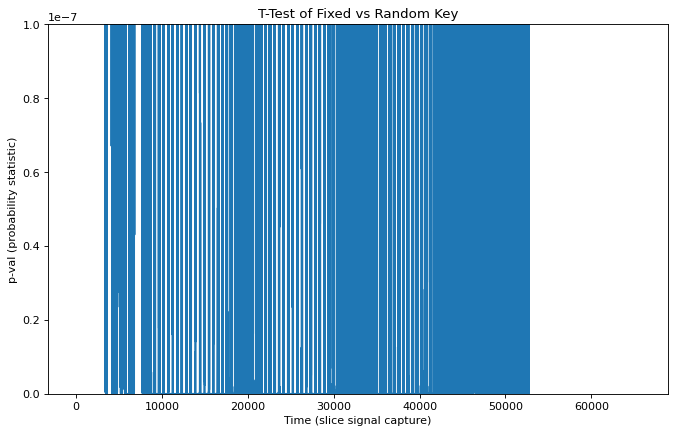

In [9]:
#Show the T-test results

#Define the visible pvalue range; this will need to be tweaked to the data for a meaningful graph
pval_threshold = 0.0000001

ShowTrace("T-Test of Fixed vs Random Key", 
          "Time (slice signal capture)", 
          "p-val (probability statistic)", 
          TTest, xdata=None, ylim=pval_threshold)


## Display Signal-to-Noise Results<a id="snr"></a>

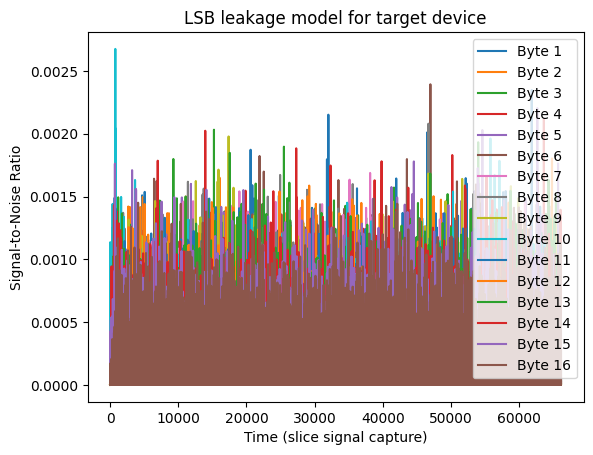

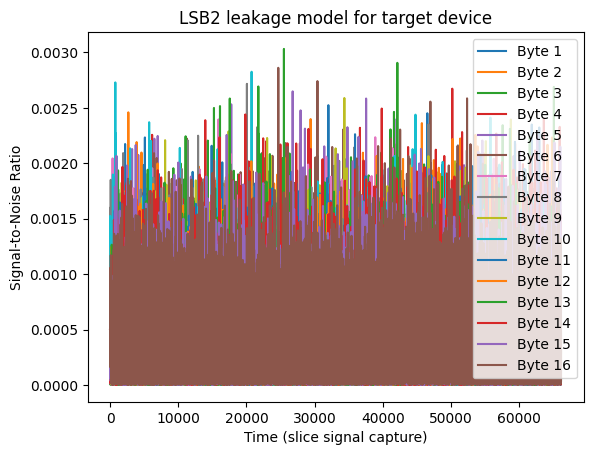

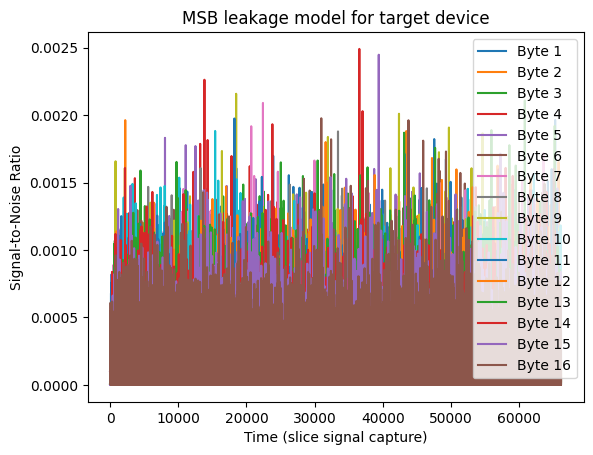

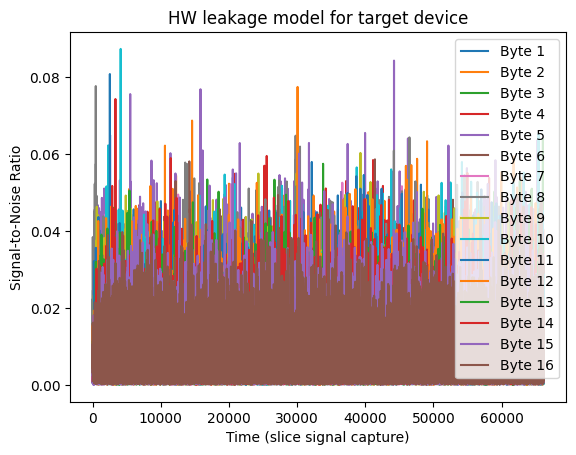

In [10]:
#Zoom in on range shown in t-test (upper an lower bounds are obtained from previous graph)
lower_poi, upper_poi = 0, 700000

# Re-organize data so it can be aggregated by leakage model
data_by_model = {}
for range_name, range_data in SNRs.items():
    for model_name, model_data in range_data.items():
        if not(model_name in data_by_model):
            data_by_model[model_name] = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
        for byte, byte_data in model_data.items():
            data_by_model[model_name][byte].extend(byte_data)


for model_name, model_data in data_by_model.items():
    plt.title(model_name+" leakage model for target device")
    plt.xlabel("Time (slice signal capture)")
    plt.ylabel("Signal-to-Noise Ratio")
    for byte, byte_data in enumerate(model_data):
        plt.plot(np.arange(lower_poi,len(byte_data[lower_poi:upper_poi])), byte_data[lower_poi:upper_poi])    
    plt.legend(['Byte 1', 'Byte 2', 'Byte 3', 'Byte 4', 'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8', 
                'Byte 9', 'Byte 10', 'Byte 11', 'Byte 12', 'Byte 13', 'Byte 14', 'Byte 15', 'Byte 16'], 
               loc='upper right')
    plt.show()

In [11]:

trim_portion = 0.2 #trims 20% from of the largest and smallest values

table = []
for model_name, model_data in data_by_model.items():
    row = []
    lr_vals = []
    row.append(model_name)
    for byte_data in model_data:
        leak_ratio = np.max(byte_data) / stats.trim_mean(byte_data, trim_portion)
        lr_vals.append(leak_ratio)
        lr = np.format_float_positional(leak_ratio, 1) #use one decimal of precision for ease of viewing
        row.append(lr)
    row.append(np.format_float_positional(np.mean(lr_vals),1))
    table.append(row)

pd.DataFrame(table, columns=['Leak Model', 'Byte 1', 'Byte 2', 'Byte 3', 'Byte 4', 'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8', 
                'Byte 9', 'Byte 10', 'Byte 11', 'Byte 12', 'Byte 13', 'Byte 14', 'Byte 15', 'Byte 16', 'Avg'])

    


,Leak Model,Byte 1,Byte 2,Byte 3,Byte 4,Byte 5,Byte 6,Byte 7,Byte 8,Byte 9,Byte 10,Byte 11,Byte 12,Byte 13,Byte 14,Byte 15,Byte 16,Avg
0,LSB,40.6,28.4,34.6,36.5,35.3,42.4,30.0,36.7,34.0,45.6,30.3,31.9,31.1,32.8,37.4,32.2,35.
1,LSB2,10.2,9.9,10.,10.7,10.4,11.2,9.4,10.9,10.4,11.2,9.0,9.4,11.6,9.5,10.5,11.2,10.4
2,MSB,34.5,34.3,30.5,43.4,29.7,30.9,37.7,31.9,37.,33.1,34.3,30.5,35.5,35.5,41.6,35.1,34.7
3,HW,11.9,12.0,13.4,15.5,14.1,13.8,12.1,13.4,12.1,17.,15.8,15.5,12.2,12.1,13.1,11.,13.5
